In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
from google.colab.files import upload
upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rgiist","key":"78e42e8652505373d8e5b08660957da8"}'}

In [ ]:
import os
import opendatasets as od
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:02<00:00, 165MB/s]


In [ ]:
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR+'/images')[:5])

['47115_2014.jpg', '43572_2013.jpg', '8044_2004.jpg', '60622_2018.jpg', '15793_2006.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from tqdm.notebooks import tqdm
import torch.nn.functional as F

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform = T.Compose([T.Resize(image_size),T.CenterCrop(image_size),T.ToTensor(),T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle= True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def Denorm(image_tensor):
    return image_tensor*stats[1][0]+stats[0][0]

def show_images(images, nmax=64):
    fig,ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(Denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
    for images,_ in dl:
        show_images(images,nmax)
        break

In [ ]:
show_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl,device)
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias= False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias= False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias= False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=2,padding=1,bias= False),
    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = to_device(discriminator,device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 32, 32])


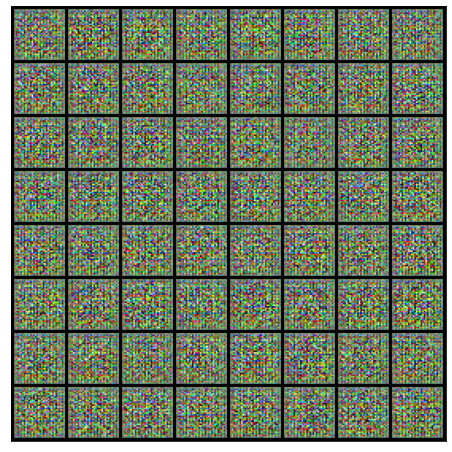

In [ ]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator,device)

In [ ]:
def fit(epochs=24,lr=0.01,start_idx=1):
    torch.cuda.empty_cuda()
    losses_g,losses_d,real_scores,fake_scores=[],[],[],[]
    opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))
    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            loss_d,real_score,fake_score=train_discriminator(real_images,opt_d)
            loss_g=train_generator(opt_g)
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        print("Epoch [{}/{}] loss_g:{:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25
history=fit(epochs,lr)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history